In [4]:
%pylab inline
from IPython.display import Audio,Image
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn import mixture
import os.path
import numpy as np
from proto import mfcc, melspec,localDist,dtw
from tools import tidigit2labels

Populating the interactive namespace from numpy and matplotlib


In [5]:
data = np.load('lab1_data.npz')['data']

In [6]:
SAMPLING_RATE = 20000
NUM_UTT = data.shape[0]

## Feature Comparison

### Same speaker, different digit (man as example o,z,3)

In [7]:
utt_o = data[0]['samples']
Audio(utt_o,rate=SAMPLING_RATE)

In [8]:
utt_z = data[2]['samples']
Audio(utt_z,rate=SAMPLING_RATE)

In [9]:
utt_3 = data[8]['samples']
Audio(utt_3,rate=SAMPLING_RATE)

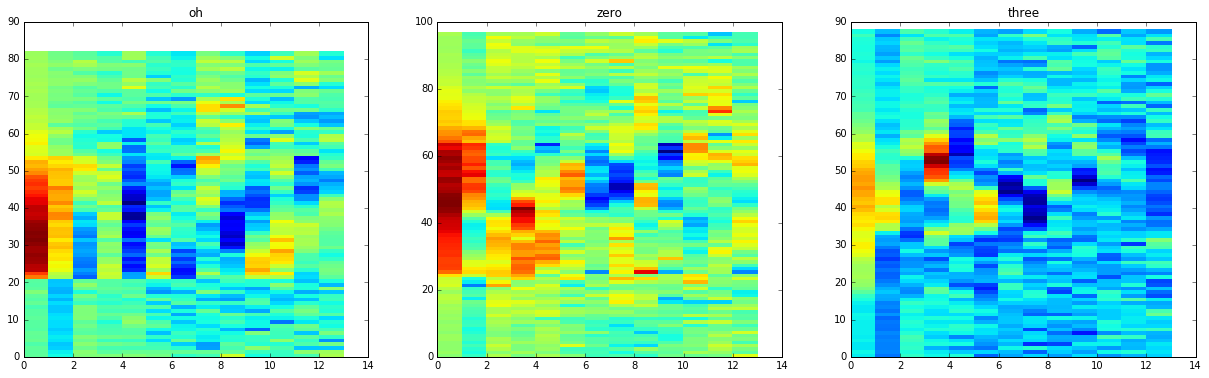

In [10]:
plt.figure(figsize=(21, 6))

plt.subplot(1,3, 1)
plt.title("oh")
pcolormesh(mfcc(utt_o))

plt.subplot(1,3, 2)
plt.title("zero")
pcolormesh(mfcc(utt_z))

plt.subplot(1,3, 3)
plt.title("three")
pcolormesh(mfcc(utt_3))

Different digit, the features **look totally different**, but in low freq. part, a specific region is always red

### Same Digit, different speaker (7)

In [9]:
utt_male = data[16]['samples']
Audio(utt_male,rate=SAMPLING_RATE)

In [10]:
utt_female = data[38]['samples']
Audio(utt_female,rate=SAMPLING_RATE)

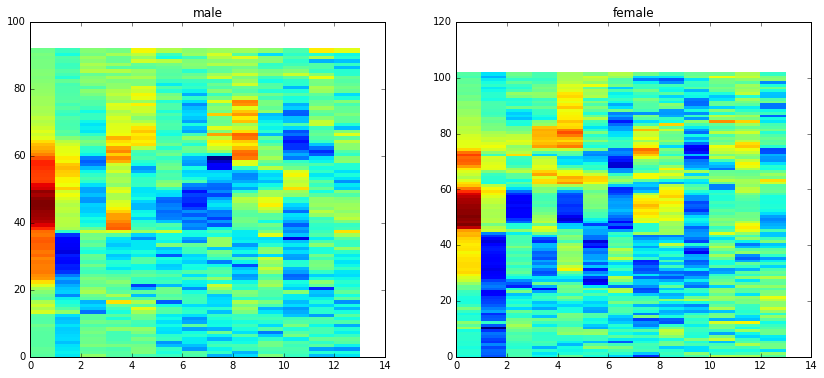

In [11]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2, 1)
plt.title("male")
pcolormesh(mfcc(utt_male))
plt.subplot(1,2, 2)
plt.title("female")
pcolormesh(mfcc(utt_female))

Originally, I want to observe the **structure** similarity between these 2 utterances (since the change is only pitch ideally), but that's not always the case. From these 2 plots, it's still hard to tell they pronunciate the same digit.

## Feature Correlation

### Correlation among MFCC features

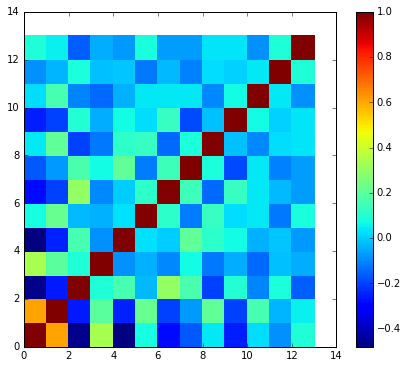

In [11]:
concat_mfccs = mfcc(data[0]['samples'])

for i in range(1,len(data)):
    concat_mfccs = np.concatenate((concat_mfccs,mfcc(data[i]['samples'])),axis=0)

corr_coeff = np.corrcoef(concat_mfccs,rowvar = False) #View mfcc[0],...mfcc[12] as variable
plt.figure(figsize=(7, 6))
pcolormesh(corr_coeff)
plt.colorbar()

### Correlation among Mel fiterbank features

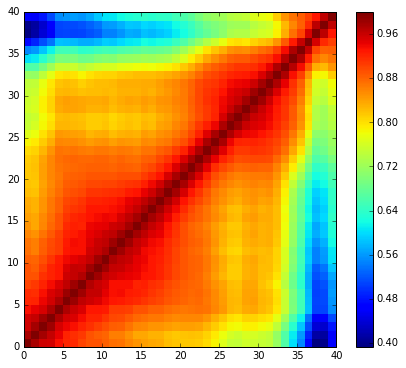

In [12]:
concat_melspecs = melspec(data[0]['samples'])

for i in range(1,len(data)):
    concat_melspecs = np.concatenate((concat_melspecs,melspec(data[i]['samples'])),axis=0)

corr_coeff = np.corrcoef(concat_melspecs,rowvar = False)
plt.figure(figsize=(7, 6))
pcolormesh(corr_coeff)
plt.colorbar()

## Comparing Utterances

### Overview

In [13]:
mfccs = [mfcc(utt['samples']) for utt in data]

In [14]:
if not os.path.exists("D.npy"):    
    D_normalized = np.zeros((NUM_UTT,NUM_UTT))
    D = np.zeros((NUM_UTT,NUM_UTT))
    for i in range(0,NUM_UTT):
        for j in range(0,NUM_UTT):
            #print(i,j)
            D_normalized[i][j] = dtw(mfccs[i],mfccs[j])[0]
            D[i][j] = dtw(mfccs[i],mfccs[j],False)[0]
    np.save("D_normalized.npy",D_normalized)
    np.save("D.npy",D)
else:
    D_normalized = np.load("D_normalized.npy")
    D = np.load("D.npy")

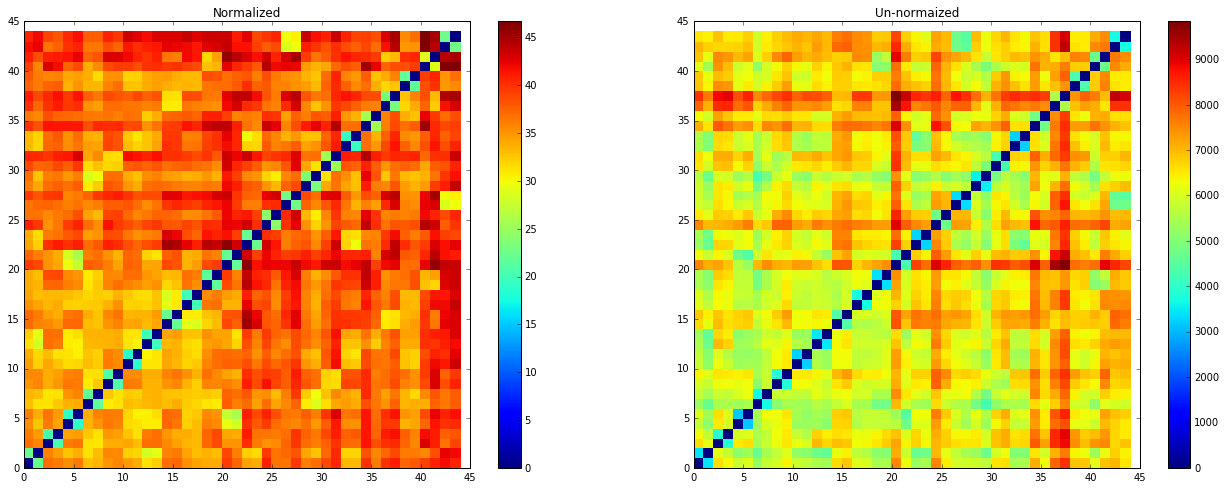

In [15]:
plt.figure(figsize=(22, 8))

plt.subplot(1,2,1)
plt.title("Normalized")
pcolormesh(D_normalized)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Un-normaized")
pcolormesh(D)
plt.colorbar()

### Different Speaker

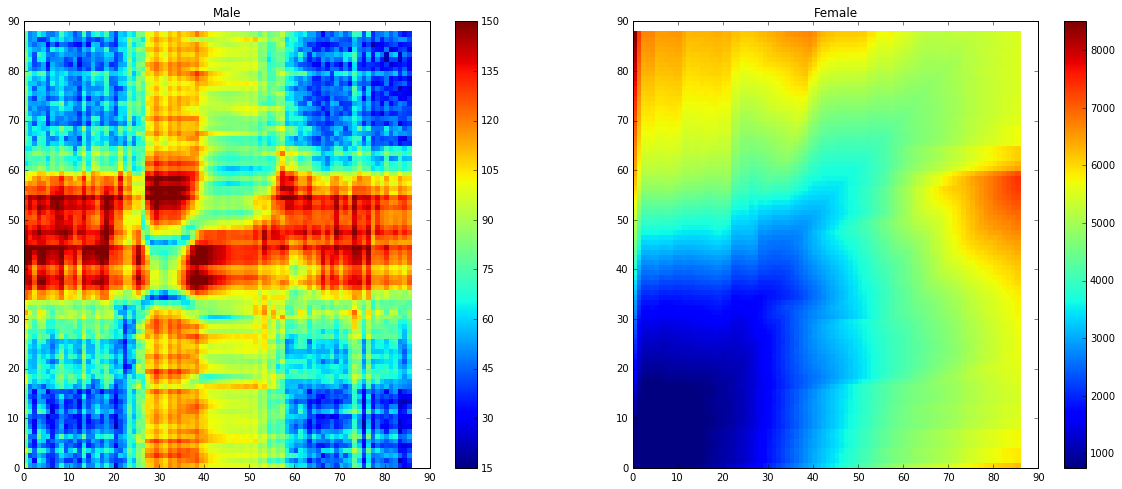

In [16]:
plt.figure(figsize=(20,8))

_,ld,ad = dtw(mfcc(data[8]['samples']),mfcc(data[30]['samples']))

plt.subplot(1,2,1)
plt.title("Male")
pcolormesh(ld)
plt.colorbar()
plt.clim(15,150)

plt.subplot(1,2,2)
plt.title("Female")
pcolormesh(ad)
plt.colorbar()
plt.clim(750,8500)

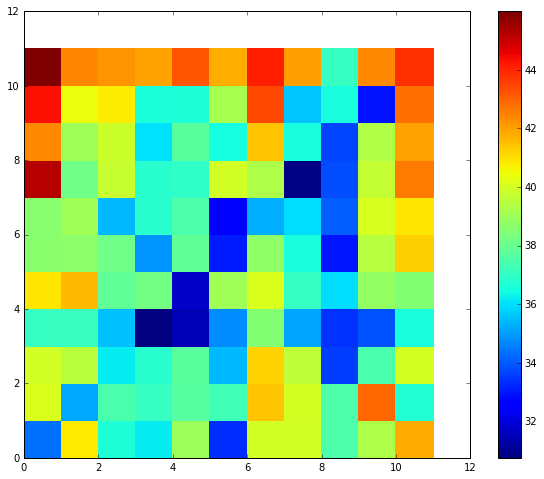

In [30]:
D_df_speaker = np.zeros((11,11))
for i in range(0,22,2):
    for j in range(22,44,2):
        D_df_speaker[i//2][(j-22)//2] = D_normalized[i][j]
plt.figure(figsize=(10, 8))
pcolormesh(D_df_speaker)
plt.colorbar()
#plt.clim(30,47)

Basically, we can observe the the values in diagonal axis are relatively smaller, because they represent same digit (but pronunciated by different speakers)

But the '9' pronunciation has large difference. The following is my observation.

In [15]:
utt_male = data[20]['samples'] #9
#utt_male = data[0]['samples'] #o
Audio(utt_male,rate=SAMPLING_RATE)

In [45]:
utt_female = data[42]['samples'] #9
#utt_female = data[22]['samples']#o
Audio(utt_female,rate=SAMPLING_RATE)

Guess it's because the 'blip' sound (for clicking the recorder or something like that) after sound.

### Different Digit

**Note: Since the diagonal will always be zero, so I scaled this value for more discriminative colormap.**

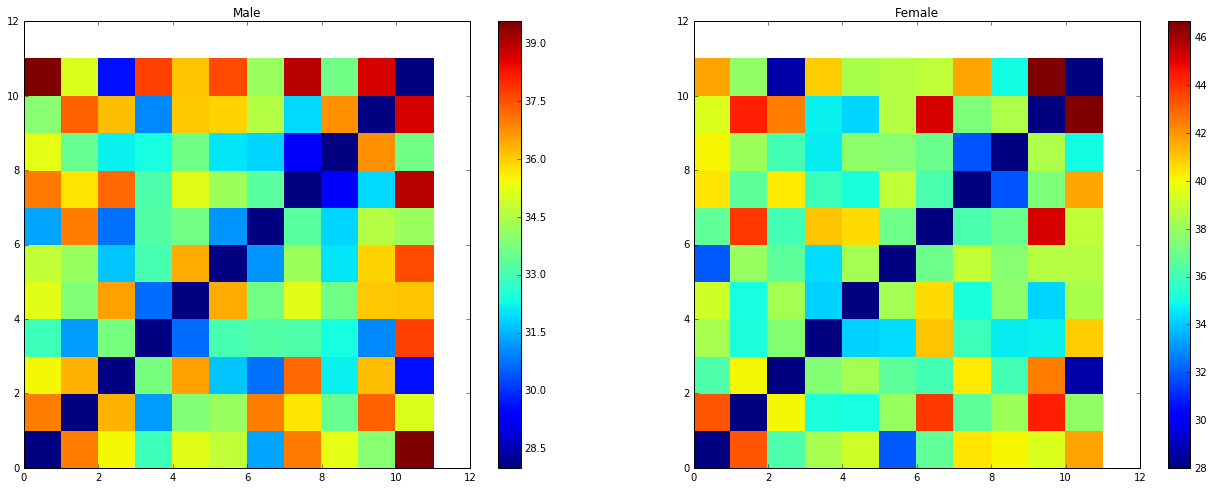

In [18]:
D_df_digit_male = np.zeros((11,11))
D_df_digit_female = np.zeros((11,11))

for i in range(0,22,2):
    for j in range(0,22,2):
        D_df_digit_male[i//2][j//2] = D_normalized[i][j]
        if i == j : D_df_digit_male[i//2][j//2] = 28

for i in range(22,44,2):
    for j in range(22,44,2):
        D_df_digit_female[(i-22)//2][(j-22)//2] = D_normalized[i][j]
        if i == j: D_df_digit_female[(i-22)//2][(j-22)//2] = 28

plt.figure(figsize=(22, 8))

plt.subplot(1,2,1)
plt.title("Male")
pcolormesh(D_df_digit_male)
plt.colorbar()
#plt.clim(30,47)

plt.subplot(1,2,2)
plt.title("Female")
pcolormesh(D_df_digit_female)
plt.colorbar()
#plt.clim(30,47)

From above, we can obaerve that different digits will cause large difference of features. (performance is alike even between different speakers, although a little bit downgrade)

### Hierarchical Clustering

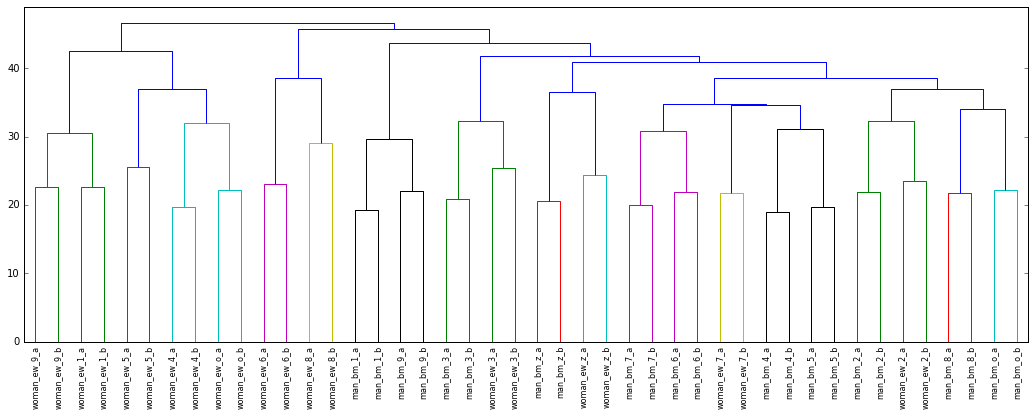

In [19]:
#np.allclose(D_normalized[2][3],squareform(squareform(D_normalized))[2][3])
plt.figure(figsize=(18, 6))
dendrogram(linkage(squareform(D_normalized),'complete'),labels = tidigit2labels(data));

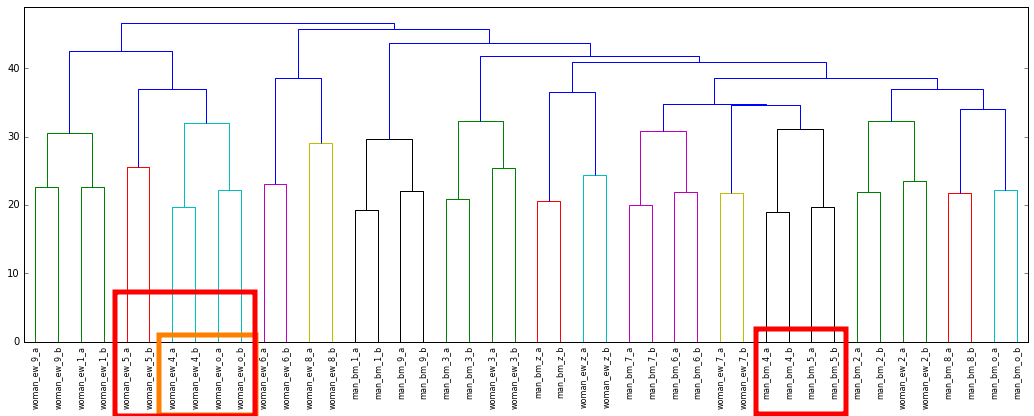

In [20]:
Image('cluster.png')

#### Observation

* `foo_a`, `foo_b` will be clustered first (same speaker, same digit, pretty intuitive)
* In general, `man_foo`, `woman_foo` will be separated at lower level
* Some digits with similar phonemes will be clustered together at lower level
    * four vs oh *[same suffix]*
    * four vs five *[same prefix]*
    * seven vs six *[same prefix]*


In [21]:
utt_o = data[22]['samples']
utt_4 = data[22 + (6-1)*2]['samples']
utt_5 = data[22 + (7-1)*2]['samples']
utt_6 = data[22+(8-1)*2]['samples']
utt_7 = data[22+(9-1)*2]['samples']
utt_9 = data[22 + (11-1)*2]['samples']
#Audio(utt_7,rate=SAMPLING_RATE)

#### Same prefix

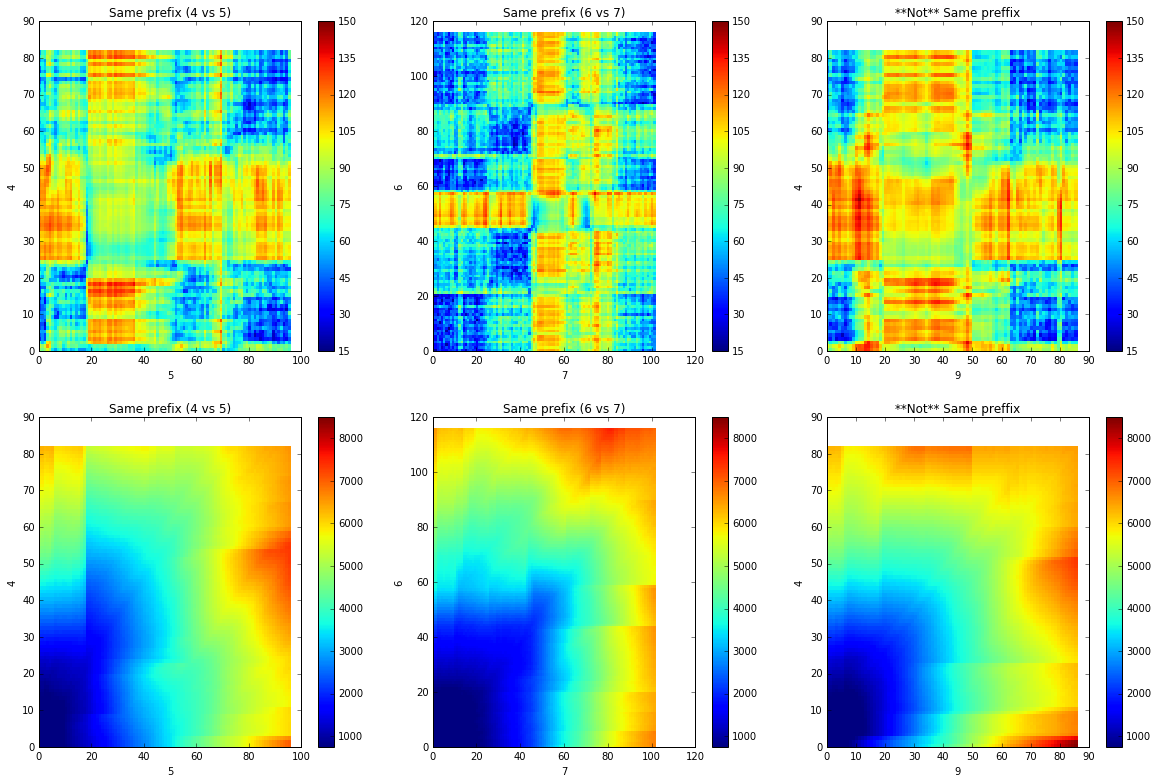

In [22]:
plt.figure(figsize=(20, 13))

plt.subplot(2,3, 1)
_,ld_4_5,ad_4_5 = dtw(mfcc(utt_4),mfcc(utt_5))
plt.ylabel('4')
plt.xlabel('5')
plt.title('Same prefix (4 vs 5)')
pcolormesh(ld_4_5)
plt.clim(15,150)
plt.colorbar()

plt.subplot(2,3, 2)
_,ld_6_7,ad_6_7 = dtw(mfcc(utt_6),mfcc(utt_7))
plt.ylabel('6')
plt.xlabel('7')
plt.title('Same prefix (6 vs 7)')
pcolormesh(ld_6_7)
plt.clim(15,150)
plt.colorbar()

plt.subplot(2,3,3)
_,ld_4_9,ad_4_9 = dtw(mfcc(utt_4),mfcc(utt_9))
plt.ylabel('4')
plt.xlabel('9')
plt.title('**Not** Same preffix')
pcolormesh(ld_4_9)
plt.clim(15,150)
plt.colorbar()


plt.subplot(2,3, 4)
_,ld_4_5,ad_4_5 = dtw(mfcc(utt_4),mfcc(utt_5))
plt.ylabel('4')
plt.xlabel('5')
plt.title('Same prefix (4 vs 5)')
pcolormesh(ad_4_5)
plt.clim(750,8500)
plt.colorbar()

plt.subplot(2,3, 5)
_,ld_6_7,ad_6_7 = dtw(mfcc(utt_6),mfcc(utt_7))
plt.ylabel('6')
plt.xlabel('7')
plt.title('Same prefix (6 vs 7)')
pcolormesh(ad_6_7)
plt.clim(750,8500)
plt.colorbar()

plt.subplot(2,3,6)
_,ld_4_9,ad_4_9 = dtw(mfcc(utt_4),mfcc(utt_9))
plt.ylabel('4')
plt.xlabel('9')
plt.title('**Not** Same preffix')
pcolormesh(ad_4_9)
plt.clim(750,8500)
plt.colorbar()

The blue rectangle region in left-down corner is larger if same prefix

#### Same suffix

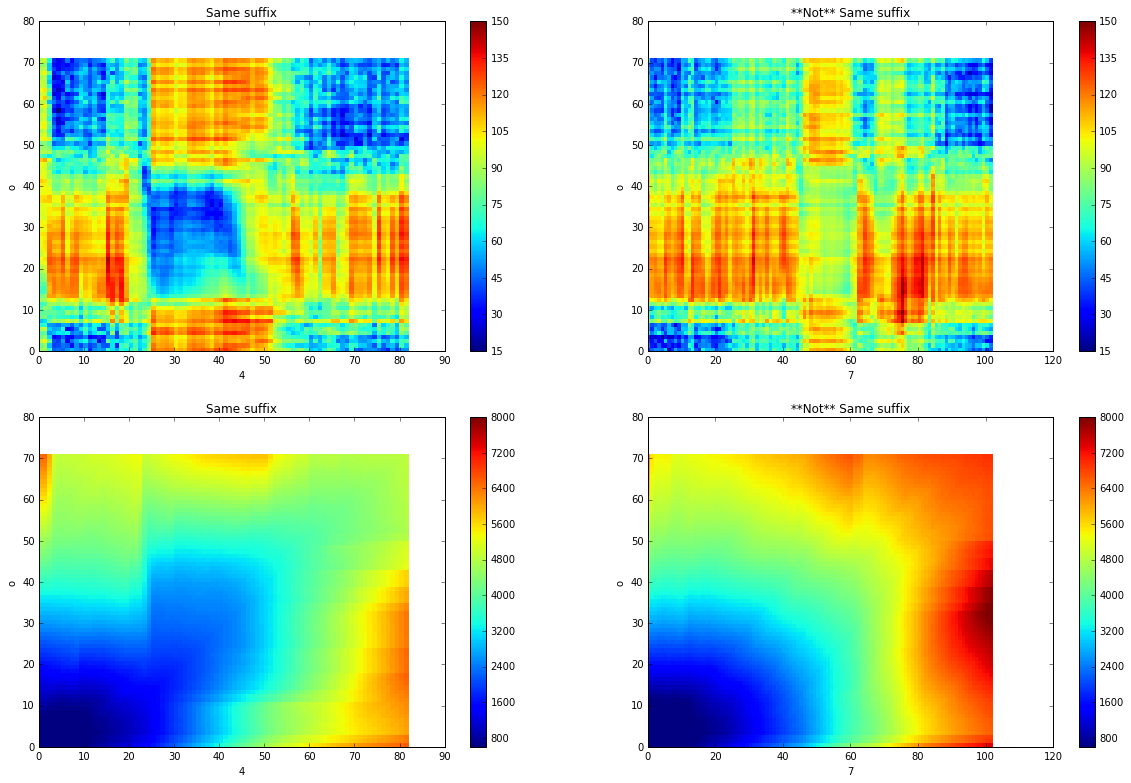

In [23]:
plt.figure(figsize=(20, 13))

plt.subplot(2,2, 1)
_,ld_o_4,ad_o_4 = dtw(mfcc(utt_o),mfcc(utt_4))
plt.ylabel('o')
plt.xlabel('4')
plt.title('Same suffix')
pcolormesh(ld_o_4)
plt.clim(15,150)
plt.colorbar()




plt.subplot(2,2, 2)
_,ld_o_7,ad_o_7 = dtw(mfcc(utt_o),mfcc(utt_7))
plt.ylabel('o')
plt.xlabel('7')
plt.title('**Not** Same suffix')
pcolormesh(ld_o_7)
plt.clim(15,150)
plt.colorbar()

plt.subplot(2,2, 3)
_,ld_o_4,ad_o_4 = dtw(mfcc(utt_o),mfcc(utt_4))
plt.ylabel('o')
plt.xlabel('4')
plt.title('Same suffix')
pcolormesh(ad_o_4)
plt.clim(600,8000)
plt.colorbar()




plt.subplot(2,2, 4)
_,ld_o_7,ad_o_7 = dtw(mfcc(utt_o),mfcc(utt_7))
plt.ylabel('o')
plt.xlabel('7')
plt.title('**Not** Same suffix')
pcolormesh(ad_o_7)
plt.clim(600,8000)
plt.colorbar()

In local distance matrix, the blue rectangle resion at right-upper corner is larger.

## Explore Speech Segments with Clustering

In [24]:
mfccs_mat = mfccs[0]

for i in range(1,len(mfccs)):
    mfccs_mat = np.vstack([mfccs_mat,mfccs[i]])

In [25]:
#mfccs_mat.shape
gmm_4 = mixture.GaussianMixture(n_components=4).fit(mfccs_mat)
gmm_8 =  mixture.GaussianMixture(n_components=8).fit(mfccs_mat)
gmm_16 =  mixture.GaussianMixture(n_components=16).fit(mfccs_mat)
gmm_32 =  mixture.GaussianMixture(n_components=32).fit(mfccs_mat)

In [26]:
utt7_1 = data[16]['samples']
utt7_2 = data[17]['samples']
utt7_3 = data[38]['samples']
utt7_4 = data[39]['samples']

utto_1 = data[0]['samples']
utto_3 = data[22]['samples']
utt4_1 = data[10]['samples']
utt4_3 = data[32]['samples']
utt5_1 = data[12]['samples']
utt5_3 = data[34]['samples']
#utt6_4 = data[37]['samples']
Audio(utto_3,rate=SAMPLING_RATE)

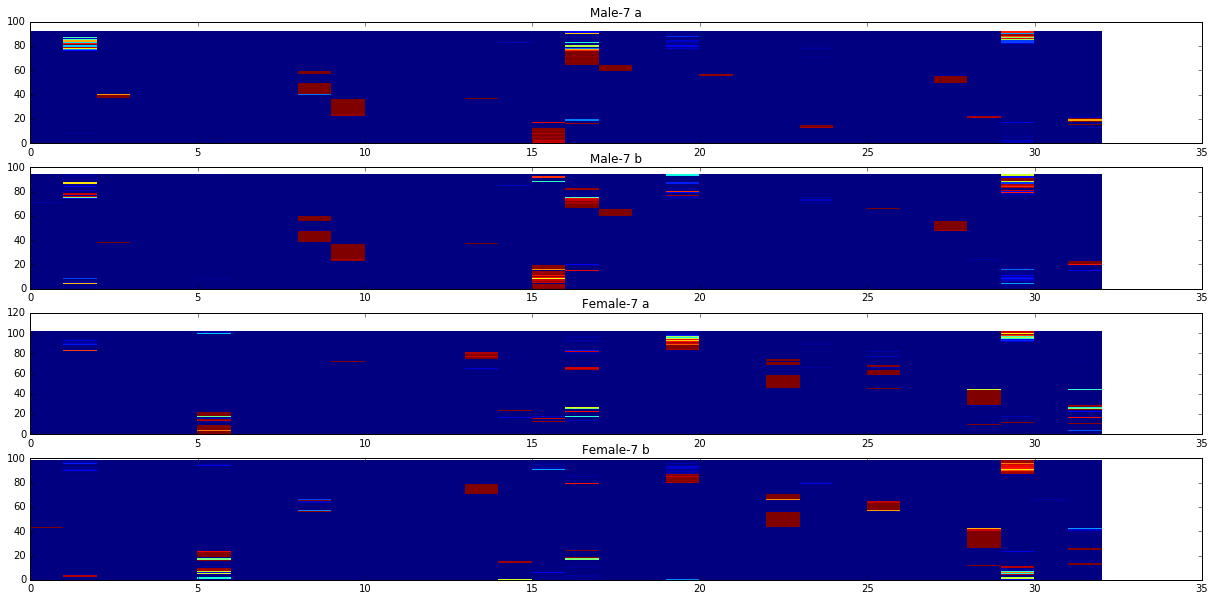

In [27]:
plt.figure(figsize=(21, 10))

plt.subplot(4,1, 1)
plt.title("Male-7 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt7_1)))

plt.subplot(4,1, 2)
plt.title("Male-7 b")
pcolormesh(gmm_32.predict_proba(mfcc(utt7_2)))

plt.subplot(4,1, 3)
plt.title("Female-7 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt7_3)))

plt.subplot(4,1, 4)
plt.title("Female-7 b")
pcolormesh(gmm_32.predict_proba(mfcc(utt7_4)))

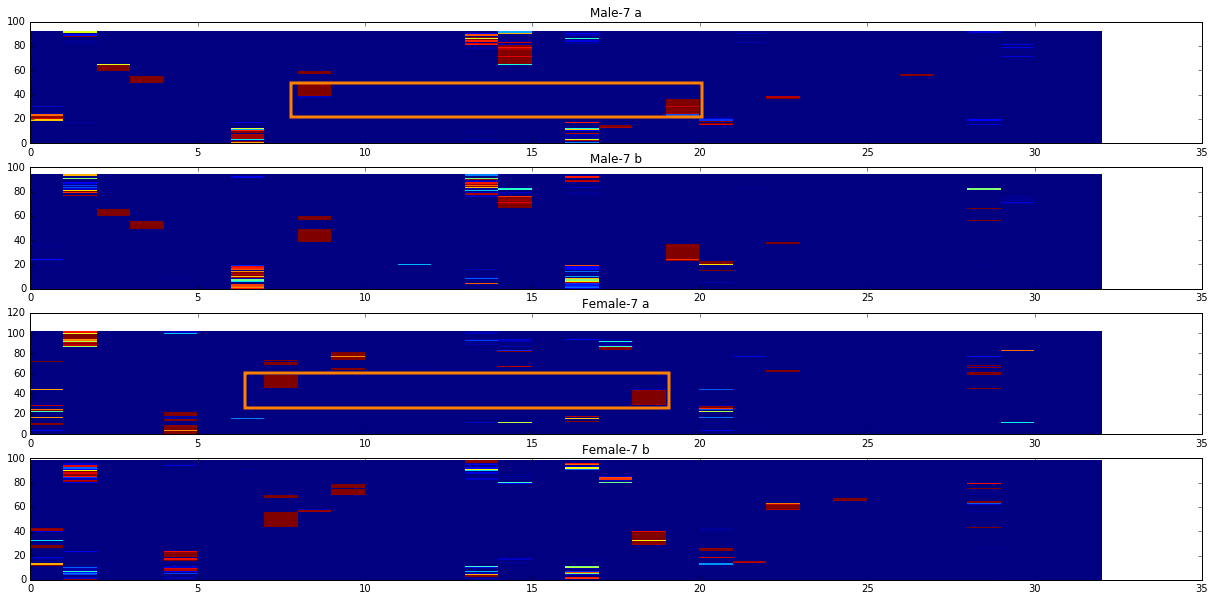

In [41]:
Image('gmm_32_7.png')

Looks like frequency shift (?  s'e'ven

### Same prefix

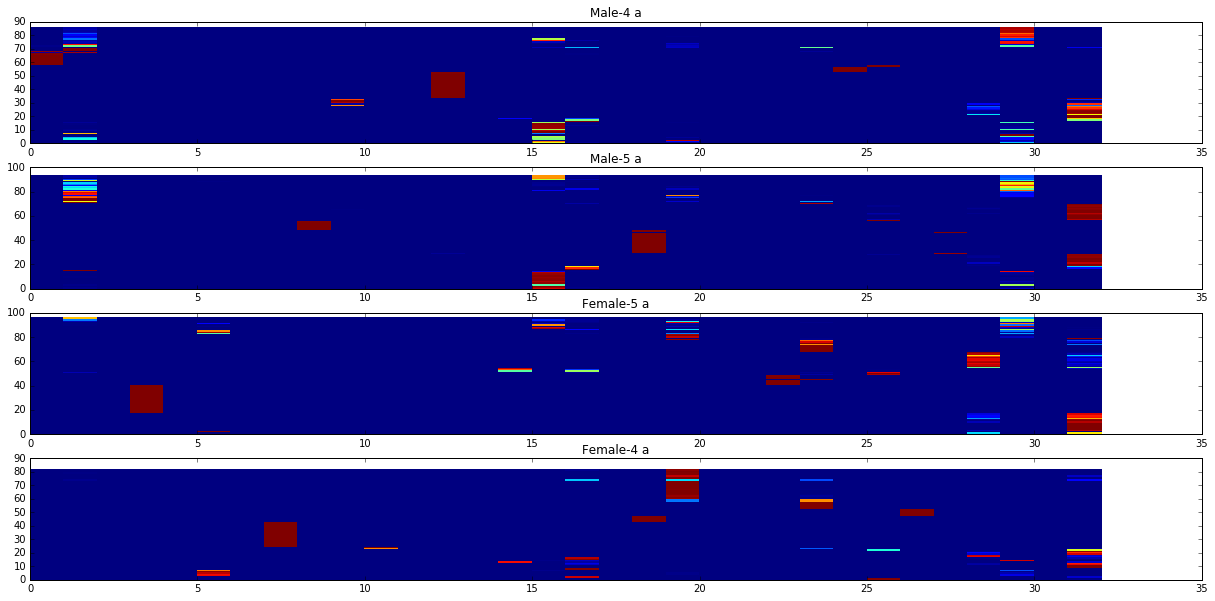

In [28]:
plt.figure(figsize=(21, 10))

plt.subplot(4,1, 1)
plt.title("Male-4 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt4_1)))

plt.subplot(4,1, 2)
plt.title("Male-5 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt5_1)))

plt.subplot(4,1, 3)
plt.title("Female-5 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt5_3)))

plt.subplot(4,1, 4)
plt.title("Female-4 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt4_3)))

### Same suffix

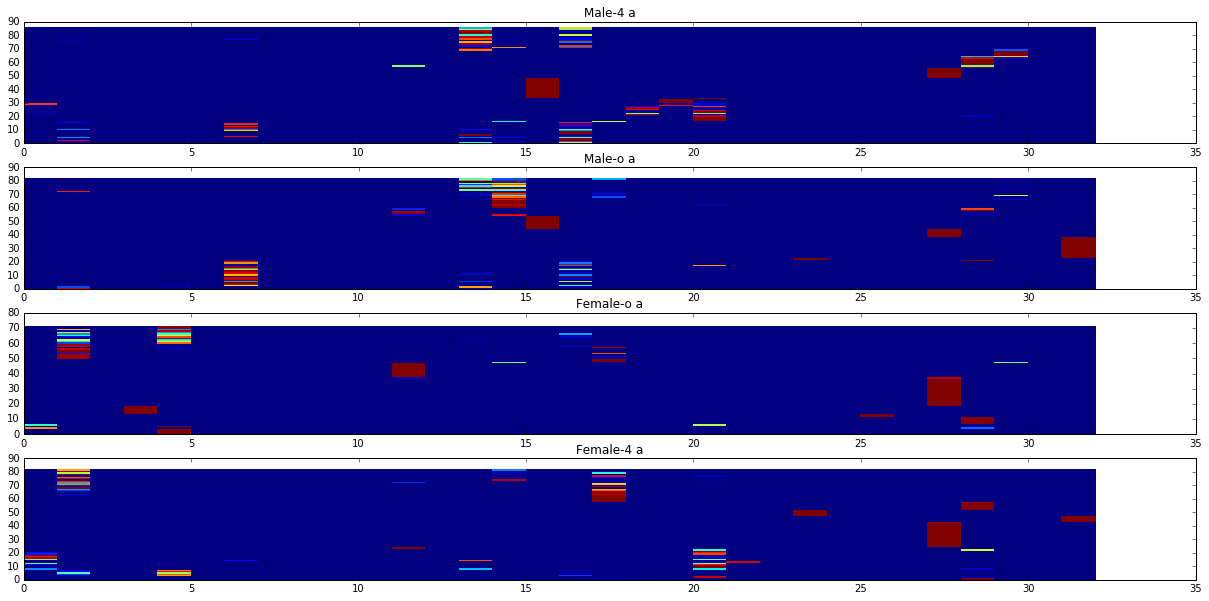

In [51]:
plt.figure(figsize=(21, 10))

plt.subplot(4,1, 1)
plt.title("Male-4 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt4_1)))

plt.subplot(4,1, 2)
plt.title("Male-o a")
pcolormesh(gmm_32.predict_proba(mfcc(utto_1)))

plt.subplot(4,1, 3)
plt.title("Female-o a")
pcolormesh(gmm_32.predict_proba(mfcc(utto_3)))

plt.subplot(4,1, 4)
plt.title("Female-4 a")
pcolormesh(gmm_32.predict_proba(mfcc(utt4_3)))

In above suffix and prefix experiment, I **want to find whether there exists some specific patterns (specific components activated at specific frames) among those utterances**. If such patterns exist, we can claim they are somehow related to specific phonemes.and independent with different speakers.
However, it's hard to find such patterns...QAQ

Although there might be some patterns exist within the speaker (among different digits with either same suffix or prefix), we cannot say they are related to phoneme because that they might be some attributes of speaker.